In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [2]:
pip install numpy scipy matplotlib scikit-learn rasterio pandas geopandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 63.4 MB/s eta 0:00:00


In [3]:
import os

# Make the desired folder as Current Working Directory
os.chdir('/content/drive/MyDrive/FinalProjectML')

In [4]:
#Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
import geopandas as gpd
from shapely.geometry import Point
import rasterio.mask
from sklearn.model_selection import train_test_split

In [5]:
# Open the Landsat images
#landsat_2001 = rasterio.open('2001_image.tif')
landsat_2013 = rasterio.open('2013.tif')
landsat_2023 = rasterio.open('2023.tif')

# Open the NLCD labels
#nlcd_2001 = rasterio.open('2001_nlcd.tif')
#nlcd_2011 = rasterio.open('2011_nlcd.tif')
nlcd = rasterio.open('NLCD.tif')

In [6]:
#img2001 = landsat_2001.read()
img2013 = landsat_2013.read()
img2023 = landsat_2023.read()

print(img2013.shape)
print(img2023.shape)

(7, 2447, 2410)
(7, 2447, 2410)


In [7]:
# Convert to float and Convert nodata to np.nan for all three images


#2013
img2013 = img2013.astype(float)
img2013[img2013 == np.float32(landsat_2013.nodata)] = np.nan

#2023
img2023 = img2023.astype(float)
img2023[img2023 == np.float32(landsat_2023.nodata)] = np.nan

In [8]:
#Normalize the values
img2013 = img2013 / 65536
img2023 = img2023 / 65536

In [9]:
#Create 10,000 sample points to cover our boundaries and export the shapefile
def create_randompoints_shapefile(raster_path, output_shapefile, num_points=10000):
    with rasterio.open(raster_path) as src:
        bounds = src.bounds
        data = src.read(1)
        transform = src.transform
        crs = src.crs
        mask = (data == src.nodata)
    valid_data_mask = ~mask
    points = []
    while len(points) < num_points:
        x = np.random.uniform(bounds.left, bounds.right)
        y = np.random.uniform(bounds.bottom, bounds.top)
        point = Point(x, y)
        row, col = rasterio.transform.rowcol(transform, x, y)
        if (row >= 0 and row < valid_data_mask.shape[0]) and (col >= 0 and col < valid_data_mask.shape[1]):
            if valid_data_mask[row, col]:
                points.append(point)
    gdf_points = gpd.GeoDataFrame(crs=crs, geometry=points)
    gdf_points.to_file(output_shapefile, driver='ESRI Shapefile')

In [10]:
#Create it for the 2013 raster but will be used for all rasters to keep consistency
raster_path = '2013.tif'
output_shapefile = 'shapefile6.shp'
create_randompoints_shapefile(raster_path, output_shapefile, num_points=10000)

In [11]:
import geopandas as gpd
from pyproj import CRS

# Load the shapefile
shapefile_path = 'shapefile6.shp'
gdf = gpd.read_file(shapefile_path)

# Define the target CRS (WGS 1984 UTM 16N)
target_crs = CRS.from_epsg(32616)  # EPSG code for WGS 1984 UTM 16N

# Reproject the GeoDataFrame to the target CRS
gdf_reprojected = gdf.to_crs(target_crs)

# Save the reprojected shapefile
output_shapefile_path = 'reprojected_shapefile.shp'
gdf_reprojected.to_file(output_shapefile_path)


In [12]:
#reimport the shapefile as points
points = gpd.read_file('reprojected_shapefile.shp')

points

,FID,geometry
0,0,POINT (-1857813.740 4160794.558)
1,1,POINT (-1858376.676 4120839.027)
2,2,POINT (-1837440.977 4132292.928)
3,3,POINT (-1850402.429 4149879.547)
4,4,POINT (-1835575.430 4128505.429)
...,...,...
9995,9995,POINT (-1844950.392 4151142.781)
9996,9996,POINT (-1834907.207 4147517.505)
9997,9997,POINT (-1862664.973 4131403.853)
9998,9998,POINT (-1844251.653 4124452.892)


In [13]:
import pandas as pd

# Assuming df is your DataFrame
points.rename(columns={'FID': 'UID'}, inplace=True)
points


,UID,geometry
0,0,POINT (-1857813.740 4160794.558)
1,1,POINT (-1858376.676 4120839.027)
2,2,POINT (-1837440.977 4132292.928)
3,3,POINT (-1850402.429 4149879.547)
4,4,POINT (-1835575.430 4128505.429)
...,...,...
9995,9995,POINT (-1844950.392 4151142.781)
9996,9996,POINT (-1834907.207 4147517.505)
9997,9997,POINT (-1862664.973 4131403.853)
9998,9998,POINT (-1844251.653 4124452.892)


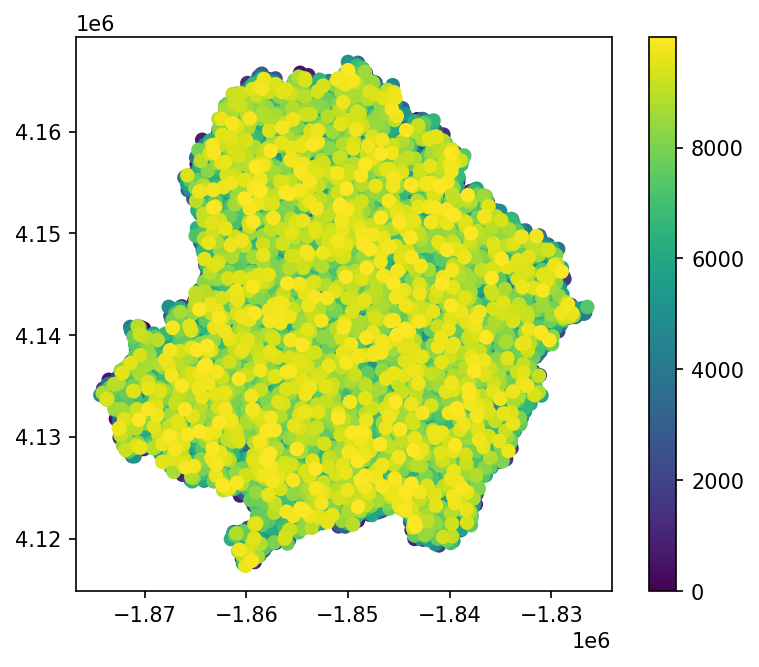

In [14]:
#visualization of the points on the shapefile
fig, ax = plt.subplots(1, 1, dpi=150)

points.plot(column='UID', ax=ax, legend=True)

plt.show()

##Extract Values From NLCD Classes

In [15]:
#Create a function to exract the values from the NLCD raster
def extract_values_nlcd(shapes, raster):
    results = []

    for idx, geometry in shapes.iterrows():
        out_image, out_transform = rasterio.mask.mask(raster, [geometry['geometry']], crop=True, all_touched=True)

        no_data = raster.nodata
        if no_data is not None:
            out_image = out_image[out_image != no_data]

        unique, counts = np.unique(out_image, return_counts=True)

        for value, count in zip(unique, counts):
            results.append({'UID': idx, 'Value': value, 'Count': count})

    results_df = pd.DataFrame(results)

    return results_df

In [16]:
#Extract the class values from the NLCD
extracted_values= extract_values_nlcd(points, nlcd)

# Print the extracted values
print(extracted_values)

        UID  Value  Count
0         0     28      1
1         0     52      1
2         0    155      1
3         0    199      1
4         1     42      1
...     ...    ...    ...
39967  9998    199      1
39968  9999     71      1
39969  9999     76      1
39970  9999    108      1
39971  9999    126      1

[39972 rows x 3 columns]


Extract Values Form Landsat Images

In [17]:
#Create a function to exract the values from the landsat raster 2013

def extract_pixel_value_from_point(point_shape, image_src, image_np):
    values_dict = {}
    for i, point in enumerate(point_shape['geometry']):

        x = point.xy[0][0]
        y = point.xy[1][0]

        row, col = image_src.index(x, y)
        values = image_np[:, row, col]

        uid = point_shape.iloc[i, 0]

        values_dict[uid] = values


    values_df = pd.DataFrame(values_dict).T
    values_df.reset_index(inplace=True)
    values_df.columns = ['UID', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']
    return values_df

In [18]:
#Extract the reflectance values from the 2001 landsat raster
reflectance2013 = extract_pixel_value_from_point(points, landsat_2013, img2013)
reflectance2013

,UID,B1,B2,B3,B4,B5,B6,B7
0,0,1.420517e-06,1.670189e-06,0.000002,0.000003,0.000004,0.000006,0.000005
1,1,7.398987e-07,8.536148e-07,0.000001,0.000002,0.000005,0.000004,0.000003
2,2,1.224556e-06,1.538429e-06,0.000002,0.000003,0.000005,0.000006,0.000005
3,3,1.229591e-06,1.630325e-06,0.000002,0.000003,0.000004,0.000006,0.000005
4,4,9.018707e-07,1.209869e-06,0.000002,0.000003,0.000004,0.000005,0.000004
...,...,...,...,...,...,...,...,...
9995,9995,1.300087e-06,1.686974e-06,0.000002,0.000003,0.000004,0.000006,0.000005
9996,9996,1.265259e-06,1.629066e-06,0.000002,0.000003,0.000004,0.000005,0.000004
9997,9997,1.508637e-06,1.892586e-06,0.000003,0.000003,0.000005,0.000006,0.000004
9998,9998,9.434128e-07,1.111679e-06,0.000002,0.000002,0.000003,0.000005,0.000004


In [19]:
#remove the coastal aerosol band and the SWIR 2 bands, so we match the wavelengths with the Landsat image from 2013
reflectance2013.drop(['B1', 'B7'], axis=1, inplace=True)
new_column_names = {f"B{i}": f"B{i-1}" for i in range(2, 7)}
reflectance2013.rename(columns=new_column_names, inplace=True)

reflectance2013

,UID,B1,B2,B3,B4,B5
0,0,1.670189e-06,0.000002,0.000003,0.000004,0.000006
1,1,8.536148e-07,0.000001,0.000002,0.000005,0.000004
2,2,1.538429e-06,0.000002,0.000003,0.000005,0.000006
3,3,1.630325e-06,0.000002,0.000003,0.000004,0.000006
4,4,1.209869e-06,0.000002,0.000003,0.000004,0.000005
...,...,...,...,...,...,...
9995,9995,1.686974e-06,0.000002,0.000003,0.000004,0.000006
9996,9996,1.629066e-06,0.000002,0.000003,0.000004,0.000005
9997,9997,1.892586e-06,0.000003,0.000003,0.000005,0.000006
9998,9998,1.111679e-06,0.000002,0.000002,0.000003,0.000005


#Join Classes And Reflectance

In [20]:
#join the 2013 reflectance and class values
Values_2013 = pd.merge(reflectance2013, extracted_values, on='UID')
Values_2013

,UID,B1,B2,B3,B4,B5,Value,Count
0,0,1.670189e-06,0.000002,0.000003,0.000004,0.000006,28,1
1,0,1.670189e-06,0.000002,0.000003,0.000004,0.000006,52,1
2,0,1.670189e-06,0.000002,0.000003,0.000004,0.000006,155,1
3,0,1.670189e-06,0.000002,0.000003,0.000004,0.000006,199,1
4,1,8.536148e-07,0.000001,0.000002,0.000005,0.000004,42,1
...,...,...,...,...,...,...,...,...
39967,9998,1.111679e-06,0.000002,0.000002,0.000003,0.000005,199,1
39968,9999,1.490173e-06,0.000002,0.000003,0.000004,0.000006,71,1
39969,9999,1.490173e-06,0.000002,0.000003,0.000004,0.000006,76,1
39970,9999,1.490173e-06,0.000002,0.000003,0.000004,0.000006,108,1


#REDIFINE CLASSES

In [21]:
# Redefine the classes to have less of them and more general 2013
value_mapping = {
    11: 'Non-urban',
    12: 'Non-urban',
    21: 'Urban',
    22: 'Urban',
    23: 'Urban',
    24: 'Urban',
    31: 'Non-urban',
    41: 'Non-urban',
    42: 'Non-urban',
    43: 'Non-urban',
    51: 'Non-urban',
    52: 'Non-urban',
    71: 'Non-urban',
    72: 'Non-urban',
    73: 'Non-urban',
    74: 'Non-urban',
    81: 'Non-urban',
    82: 'Non-urban',
    90: 'Non-urban',
    95: 'Non-urban'
}

for i in range(Values_2013.shape[0]):
    original_value = Values_2013.at[i, 'Value']
    if original_value in value_mapping:
        new_category = value_mapping[original_value]
    else:
        new_category = None
    Values_2013.at[i, 'Value'] = new_category

print(Values_2013)

        UID            B1        B2        B3        B4        B5      Value  \
0         0  1.670189e-06  0.000002  0.000003  0.000004  0.000006        NaN   
1         0  1.670189e-06  0.000002  0.000003  0.000004  0.000006  Non-urban   
2         0  1.670189e-06  0.000002  0.000003  0.000004  0.000006       None   
3         0  1.670189e-06  0.000002  0.000003  0.000004  0.000006       None   
4         1  8.536148e-07  0.000001  0.000002  0.000005  0.000004  Non-urban   
...     ...           ...       ...       ...       ...       ...        ...   
39967  9998  1.111679e-06  0.000002  0.000002  0.000003  0.000005       None   
39968  9999  1.490173e-06  0.000002  0.000003  0.000004  0.000006  Non-urban   
39969  9999  1.490173e-06  0.000002  0.000003  0.000004  0.000006       None   
39970  9999  1.490173e-06  0.000002  0.000003  0.000004  0.000006       None   
39971  9999  1.490173e-06  0.000002  0.000003  0.000004  0.000006       None   

       Count  
0          1  
1        

In [22]:
# Remove rows where 'Value' is None
Values_2013 = Values_2013.dropna(subset=['Value']).reset_index(drop=True)

print(Values_2013)


        UID            B1        B2        B3        B4        B5      Value  \
0         0  1.670189e-06  0.000002  0.000003  0.000004  0.000006  Non-urban   
1         1  8.536148e-07  0.000001  0.000002  0.000005  0.000004  Non-urban   
2         2  1.538429e-06  0.000002  0.000003  0.000005  0.000006  Non-urban   
3         3  1.630325e-06  0.000002  0.000003  0.000004  0.000006  Non-urban   
4         4  1.209869e-06  0.000002  0.000003  0.000004  0.000005      Urban   
...     ...           ...       ...       ...       ...       ...        ...   
10596  9995  1.686974e-06  0.000002  0.000003  0.000004  0.000006  Non-urban   
10597  9996  1.629066e-06  0.000002  0.000003  0.000004  0.000005  Non-urban   
10598  9997  1.892586e-06  0.000003  0.000003  0.000005  0.000006  Non-urban   
10599  9998  1.111679e-06  0.000002  0.000002  0.000003  0.000005  Non-urban   
10600  9999  1.490173e-06  0.000002  0.000003  0.000004  0.000006  Non-urban   

       Count  
0          1  
1        

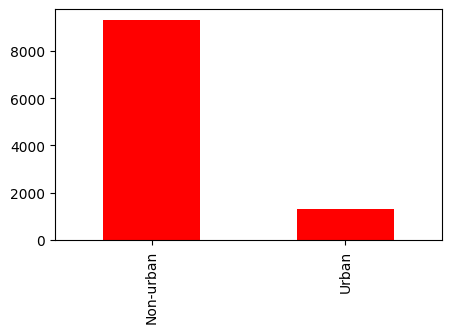

In [23]:
#count the number of points for each class
counts = Values_2013['Value'].value_counts().plot(kind='bar', figsize = (5,3), color = 'Red')


plt.show()

In [44]:
#import pandas as pd

# Assuming 'Values_2016' is your DataFrame and 'Value' is the column with 6 classes

# Determine the count of occurrences for each class
class_counts = Values_2013['Value'].value_counts()

# Find the minimum count among classes
min_count = class_counts.min()

# Group by class and sample to get equal rows for each class
Values_2013 = Values_2013.groupby('Value').apply(lambda x: x.sample(min_count)).reset_index(drop=True)

# 'balanced_data' now contains an equal number of rows for each class in the 'Value' column

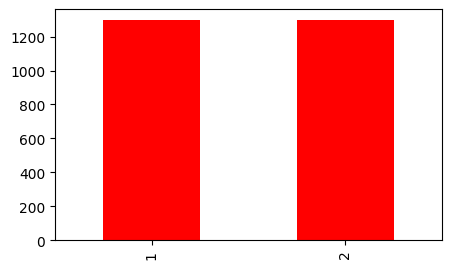

In [45]:
#count the number of points for each class
counts = Values_2013['Value'].value_counts().plot(kind='bar', figsize = (5,3), color = 'Red')


plt.show()

#Class to number

In [46]:
import pandas as pd

# Define a mapping from text labels to numbers
label_to_number = {
    "Urban": 1,
    "Non-urban": 2
    #"Developed": 3,
    #"Forest": 4,
    #"Cultivated Crops": 5,
    #"Barren Land (rock/sand/clay)": 6,
    #"Herbaceous": 7,
    #"Scrub": 8,
    #"Pasture/Hay": 8
}

# Apply the mapping to the last column based on the value in the first column
Values_2013['Value'] = Values_2013['Value'].apply(lambda x: label_to_number.get(x, x))

# Display the modified DataFrame
Values_2013

,UID,B1,B2,B3,B4,B5,Value,Count
0,530,2.164497e-06,3.036461e-06,4.018784e-06,0.000006,0.000006,1,1
1,8472,2.171631e-06,3.074646e-06,3.931503e-06,0.000005,0.000006,1,1
2,8065,1.593399e-06,2.246323e-06,2.661324e-06,0.000004,0.000005,1,1
3,6019,1.007195e-06,1.631165e-06,2.025185e-06,0.000004,0.000003,1,1
4,1695,1.432686e-06,2.270241e-06,3.138008e-06,0.000004,0.000006,1,1
...,...,...,...,...,...,...,...,...
2585,2468,1.634521e-06,2.315979e-06,3.013802e-06,0.000004,0.000006,2,1
2586,8276,4.444885e-07,8.284378e-07,7.931900e-07,0.000003,0.000002,2,1
2587,4428,1.521645e-06,2.360458e-06,3.288651e-06,0.000004,0.000006,2,1
2588,9701,1.609764e-06,2.304230e-06,2.961769e-06,0.000004,0.000006,2,1


In [47]:
# Remove rows with NaN values in specific columns
Values_2013 = Values_2013.dropna(subset=['B1', 'B2','B3','B4','B5','Count'])


In [48]:
Values_2013

,UID,B1,B2,B3,B4,B5,Value,Count
0,530,2.164497e-06,3.036461e-06,4.018784e-06,0.000006,0.000006,1,1
1,8472,2.171631e-06,3.074646e-06,3.931503e-06,0.000005,0.000006,1,1
2,8065,1.593399e-06,2.246323e-06,2.661324e-06,0.000004,0.000005,1,1
3,6019,1.007195e-06,1.631165e-06,2.025185e-06,0.000004,0.000003,1,1
4,1695,1.432686e-06,2.270241e-06,3.138008e-06,0.000004,0.000006,1,1
...,...,...,...,...,...,...,...,...
2585,2468,1.634521e-06,2.315979e-06,3.013802e-06,0.000004,0.000006,2,1
2586,8276,4.444885e-07,8.284378e-07,7.931900e-07,0.000003,0.000002,2,1
2587,4428,1.521645e-06,2.360458e-06,3.288651e-06,0.000004,0.000006,2,1
2588,9701,1.609764e-06,2.304230e-06,2.961769e-06,0.000004,0.000006,2,1


#Machine Learning

In [49]:
X = Values_2013[['B1', 'B2', 'B3', 'B4', 'B5']]
y = Values_2013['Value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [28]:
# Now check their shapes
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(7420, 5)
(7420,)
(3181, 5)
(3181,)


In [50]:
## Import modules

# Import the logistic regression classifier from sklearn
from sklearn.linear_model import LogisticRegression

# Import the decision tree classifier from sklearn
from sklearn.tree import DecisionTreeClassifier

# Import the random forest classifier from sklearn
from sklearn.ensemble import RandomForestClassifier

# Import the support vector machine classifier from sklearn
from sklearn.svm import SVC

In [51]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],  # Different number of trees
    'max_depth':  [30, 50, 100, None],  # Different max depth settings
    'min_samples_split': [2, 5, 10],  # Different minimum samples for split
    # Add more parameters to test different settings
}

# Create a Random Forest Classifier instance
rfc = RandomForestClassifier(random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Evaluate the best model on the test data
best_model = grid_search.best_estimator_
best_model_score = best_model.score(X_test, y_test)
print(f'Best Parameters: {best_params}')
print(f'Best Cross-Validation Score: {best_score * 100:.2f}%')
print(f'Best Model Accuracy (on test data): {best_model_score * 100:.2f}%')


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters: {'max_depth': 30, 'min_samples_split': 5, 'n_estimators': 300}
Best Cross-Validation Score: 51.90%
Best Model Accuracy (on test data): 51.87%


# Learning Curve

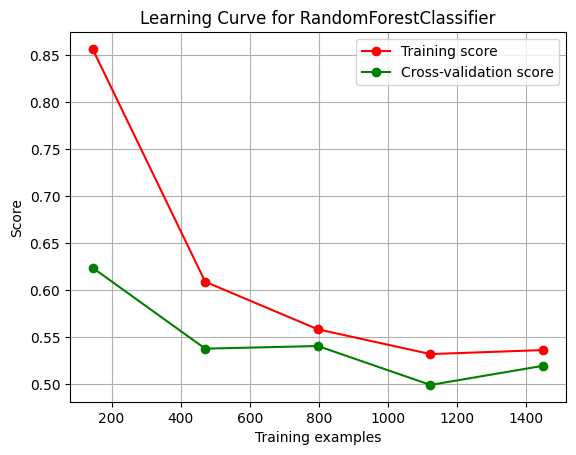

In [61]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

best_model = grid_search.best_estimator_

train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train, y_train, cv=5, n_jobs=-1,
    train_sizes=np.linspace(.1, 1.0, 5))

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.title("Learning Curve for RandomForestClassifier")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.grid()
plt.show()


# Validation curve:

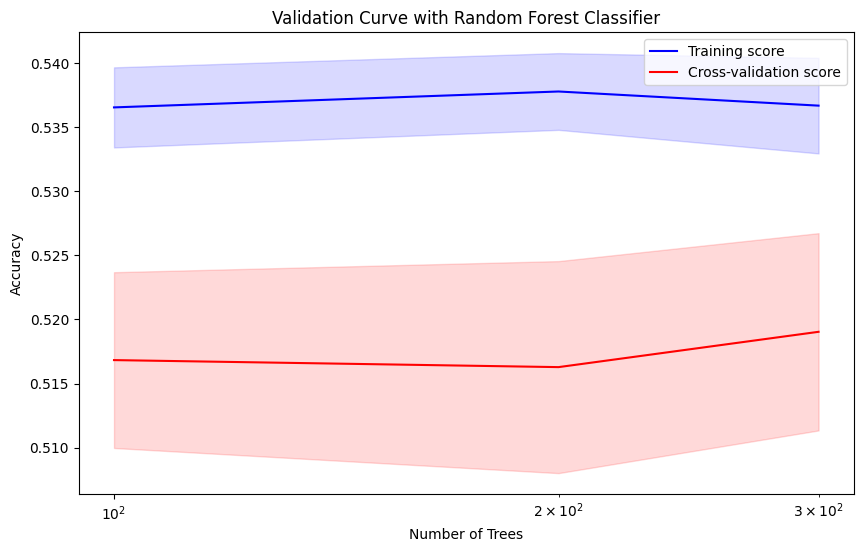

In [62]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import validation_curve

# Define the parameter grid to search
param_range = [100, 200, 300]  # Different number of trees

# Create a Random Forest Classifier instance
rfc = RandomForestClassifier(random_state=42, max_depth=50, min_samples_split=5)

# Calculate training and test scores for varying parameter values
train_scores, test_scores = validation_curve(
    rfc, X_train, y_train, param_name="n_estimators", param_range=param_range,
    cv=5, scoring="accuracy", n_jobs=-1)

# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plotting the validation curve
plt.figure(figsize=(10, 6))
plt.title('Validation Curve with Random Forest Classifier')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.semilogx(param_range, train_mean, label='Training score', color='blue')
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.15, color='blue')
plt.semilogx(param_range, test_mean, label='Cross-validation score', color='red')
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, alpha=0.15, color='red')
plt.legend(loc='best')
plt.show()


# **SVM**

In [52]:
from sklearn.svm import SVR

# Define the base estimator
svm = SVR()

# Define the parameter search space
C_values = [2**i for i in range(-5, 11)]
parameters_svm = {'kernel': ['rbf', 'linear'],
                  'C': C_values,
                  'gamma': ['scale', 'auto']}

# Define the grid search object
grid_svm = GridSearchCV(estimator=svm, param_grid=parameters_svm, cv=5, n_jobs=-1)
grid_svm.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8,
                               16, 32, 64, 128, 256, 512, 1024],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['rbf', 'linear']})

In [53]:
best_params_svm = grid_svm.best_params_
print(f'Best Parameters: {best_params_svm}')


Best Parameters: {'C': 8, 'gamma': 'scale', 'kernel': 'rbf'}


In [54]:
best_score_svm = grid_svm.best_score_
print(f'Best Cross-Validation Score: {best_score_svm * 100:.2f}%')


Best Cross-Validation Score: 15.82%


In [55]:
best_model_svm = grid_svm.best_estimator_
best_model_score_svm = best_model_svm.score(X_test, y_test)
print(f'Best Model Accuracy (on test data): {best_model_score_svm * 100:.2f}%')


Best Model Accuracy (on test data): 15.94%


In [42]:
threshold = 0.5
predicted_classes = np.where(best_model_svm.predict(X_test) > threshold, 2, 1)
cm_svm = confusion_matrix(y_test, predicted_classes)
print(cm_svm)


[[   1  366]
 [   0 2814]]


#Decision Tree

In [56]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report


In [58]:

# Define the Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=42)

# Define the parameter grid to search
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    # Add more parameters to test different settings
}

# Create the GridSearchCV object
grid_dt = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_dt.fit(X_train, y_train)

# Get the best parameters and the best score
best_params_dt = grid_dt.best_params_
best_score_dt = grid_dt.best_score_

# Evaluate the best model on the test data
best_model_dt = grid_dt.best_estimator_
y_pred_dt = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_dt)
classification_rep = classification_report(y_test, y_pred_dt)

# Print the results
print(f'Best Parameters: {best_params}')
print(f'Best Cross-Validation Score: {best_score * 100:.2f}%')
print(f'Accuracy on Test Data: {accuracy * 100:.2f}%')
print('Classification Report:')
print(classification_rep)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters: {'max_depth': 30, 'min_samples_split': 5, 'n_estimators': 300}
Best Cross-Validation Score: 51.90%
Accuracy on Test Data: 51.87%
Classification Report:
              precision    recall  f1-score   support

           1       0.74      0.06      0.11       389
           2       0.51      0.98      0.67       388

    accuracy                           0.52       777
   macro avg       0.63      0.52      0.39       777
weighted avg       0.63      0.52      0.39       777



ValueError: ignored

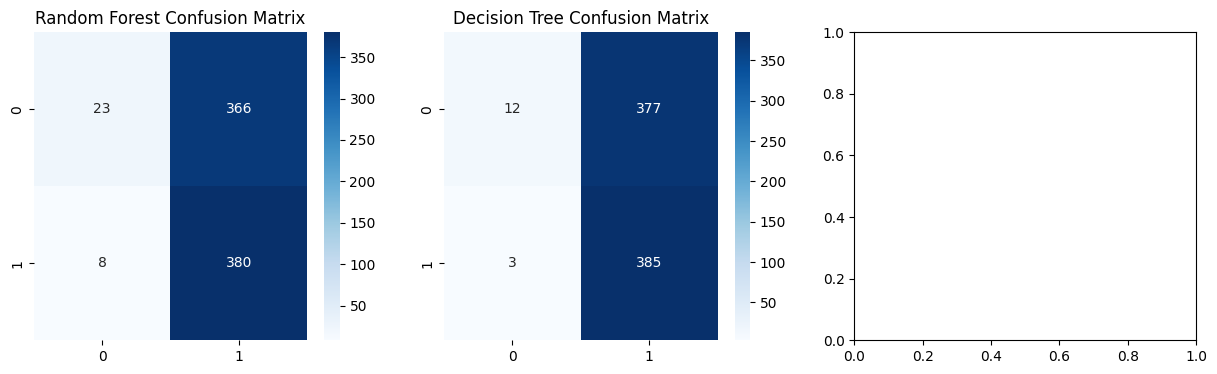

In [59]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming best_model_rf, best_model_dt, best_model_svm are already trained
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Random Forest Confusion Matrix
cm_rf = confusion_matrix(y_test, best_model.predict(X_test))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Random Forest Confusion Matrix')

# Decision Tree Confusion Matrix
cm_dt = confusion_matrix(y_test, best_model_dt.predict(X_test))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Decision Tree Confusion Matrix')

# SVM Confusion Matrix
cm_svm = confusion_matrix(y_test, predicted_classes)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', ax=axes[2])
axes[2].set_title('SVM Confusion Matrix')


plt.tight_layout()
plt.show()


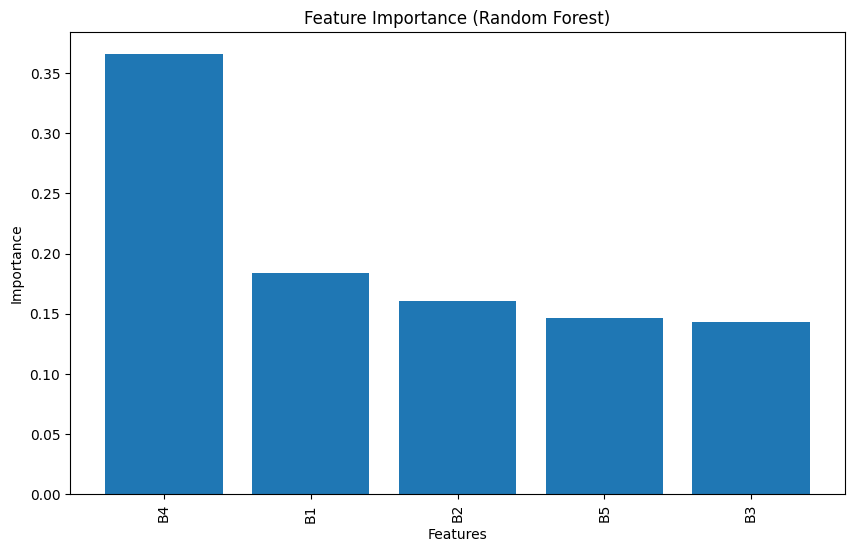

In [57]:
# Assuming best_model_rf is your trained Random Forest model

# Get feature importances
importances = best_model.feature_importances_

# Get the indices of the features in descending order of their importance
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = X_train.columns
names_sorted = [names[i] for i in indices]

# Create plot
plt.figure(figsize=(10, 6))
plt.title("Feature Importance (Random Forest)")
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), names_sorted, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()


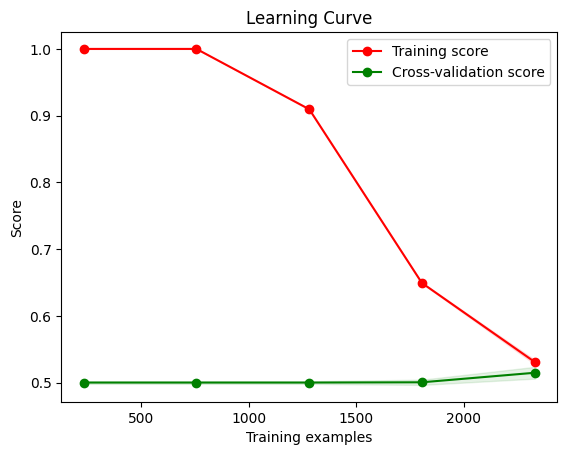

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier

# Assuming X, y are your data and target variable
# RandomForestClassifier() should be replaced with your actual classifier and parameters

train_sizes, train_scores, test_scores = learning_curve(
    RandomForestClassifier(), X, y, cv=10, scoring='accuracy', n_jobs=-1,
    train_sizes=np.linspace(.1, 1.0, 5))

# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")

plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()


In [53]:
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
import rasterio
import numpy as np
import rasterio

# Assuming 'img2003' is your input image and 'rfc' is your trained model
n_bands = img2023.shape[0]
height, width = img2023.shape[1], img2023.shape[2]
# Assuming 'img2003' is your input image and 'rfc_100' is your trained model

# Mask out NaN values (assuming NaNs are represented as np.nan in the image data)
nan_mask = np.isnan(img2023).any(axis=0)

# Reshape image data to [pixels, bands], removing NaN pixels
pixels_for_prediction = img2023[1:6, ~nan_mask].reshape(5, -1).T

# Predict land cover classes using your trained model, only for non-NaN pixels
predicted_classes = grid_search.predict(pixels_for_prediction)

# Initialize an array for the classified image, filled with NaNs (or another nodata value)
classified_image2023 = np.full((height * width,), np.nan)

# Place classified pixels back into the original image positions, skipping NaN locations
classified_image2023[~nan_mask.flatten()] = predicted_classes

# Reshape classified image back to original dimensions
classified_image2023 = classified_image2023.reshape(height, width)

# Save the classified image, preserving NaN values for the background
with rasterio.open(
    'classified_image2023.tif', 'w',
    driver='GTiff',
    height=height,
    width=width,
    count=1,  # Number of bands
    dtype=str(classified_image2023.dtype),
    crs=landsat_2023.crs,  # Replace 'landsat_2003.crs' with your actual CRS
    transform=landsat_2023.transform,  # Replace 'landsat_2003.transform' with your actual transform
    nodata=np.nan  # Set nodata value as np.nan or appropriate value for your data
) as dst:
    dst.write(classified_image2023, 1)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


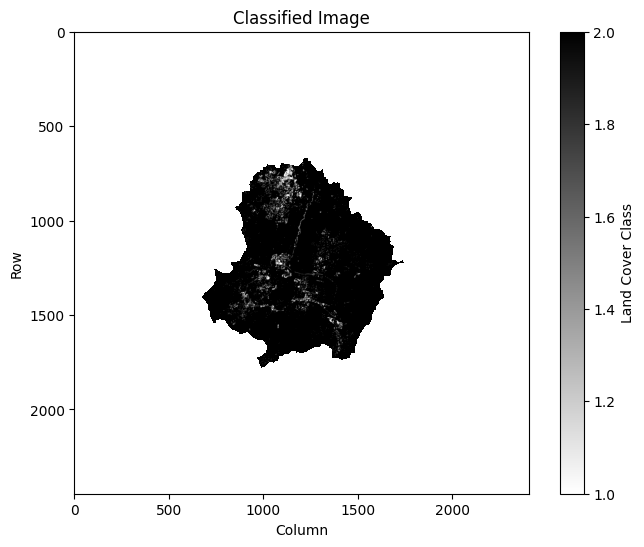

In [54]:
import matplotlib.pyplot as plt

# Plot the classified image
plt.figure(figsize=(8, 6))
plt.imshow(classified_image2023, cmap='binary')  # Change the cmap according to your land cover classes
plt.colorbar(label='Land Cover Class')
plt.title('Classified Image')
plt.xlabel('Column')
plt.ylabel('Row')
plt.show()


In [55]:
# Assuming 'img2013' is your input image and 'rfc' is your trained model
n_bands = img2013.shape[0]
height, width = img2013.shape[1], img2013.shape[2]
# Assuming 'img2003' is your input image and 'rfc_100' is your trained model

# Mask out NaN values (assuming NaNs are represented as np.nan in the image data)
nan_mask = np.isnan(img2013).any(axis=0)

# Reshape image data to [pixels, bands], removing NaN pixels
pixels_for_prediction = img2013[1:6, ~nan_mask].reshape(5, -1).T

# Predict land cover classes using your trained model, only for non-NaN pixels
predicted_classes = grid_search.predict(pixels_for_prediction)

# Initialize an array for the classified image, filled with NaNs (or another nodata value)
classified_image2013 = np.full((height * width,), np.nan)

# Place classified pixels back into the original image positions, skipping NaN locations
classified_image2013[~nan_mask.flatten()] = predicted_classes

# Reshape classified image back to original dimensions
classified_image2013 = classified_image2013.reshape(height, width)

# Save the classified image, preserving NaN values for the background
with rasterio.open(
    'classified_image2013_rf.tif', 'w',
    driver='GTiff',
    height=height,
    width=width,
    count=1,  # Number of bands
    dtype=str(classified_image2013.dtype),
    crs=landsat_2013.crs,  # Replace 'landsat_2003.crs' with your actual CRS
    transform=landsat_2013.transform,  # Replace 'landsat_2013.transform' with your actual transform
    nodata=np.nan  # Set nodata value as np.nan or appropriate value for your data
) as dst:
    dst.write(classified_image2013, 1)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


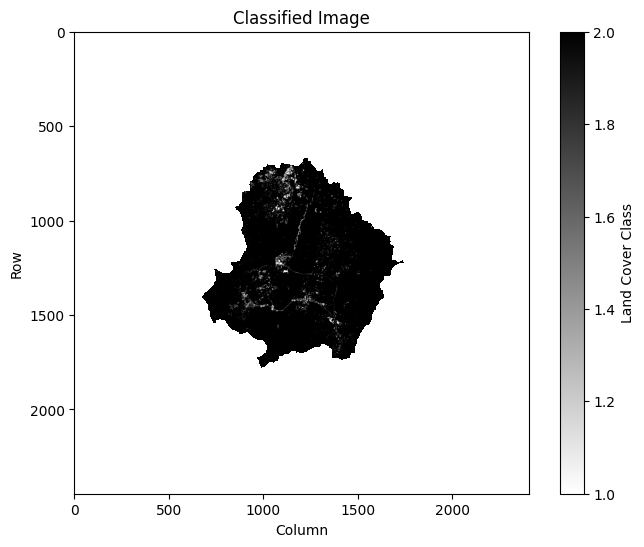

In [56]:
import matplotlib.pyplot as plt

# Plot the classified image
plt.figure(figsize=(8, 6))
plt.imshow(classified_image2013, cmap='binary')  # Change the cmap according to your land cover classes
plt.colorbar(label='Land Cover Class')
plt.title('Classified Image')
plt.xlabel('Column')
plt.ylabel('Row')
plt.show()


Random Forest